In [7]:
import kaggle
import os
import pandas as pd
#fetching the dataset
kaggle.api.authenticate()
local_path = './data_set'
if not os.path.isdir('data_set'):
    os.makedirs('data_set')
raw_data = pd.read_csv(local_path+'/train.csv')

In [204]:
X_train, y_train = raw_data.drop(['Survived'], axis=1), raw_data['Survived'].astype('bool')

In [178]:
X_train.columns[[0,2,7,9]]

Index(['PassengerId', 'Name', 'Ticket', 'Cabin'], dtype='object')

In [179]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


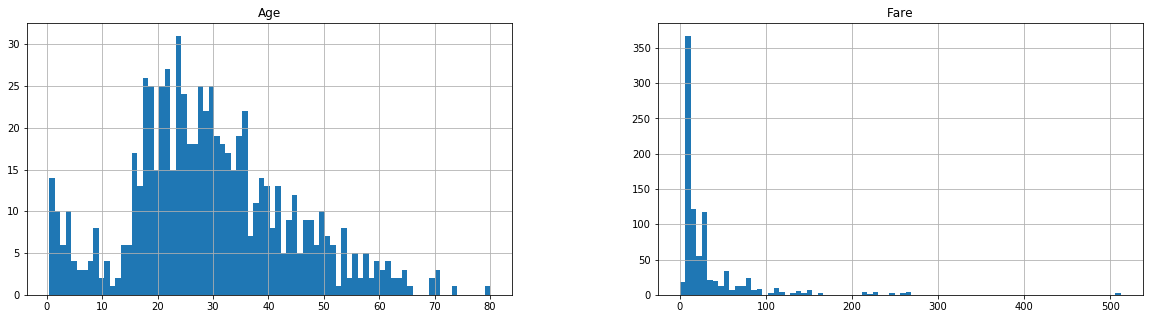

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
X_train[['Age','Fare']].hist(bins =80,figsize=(20,5))
plt.show()

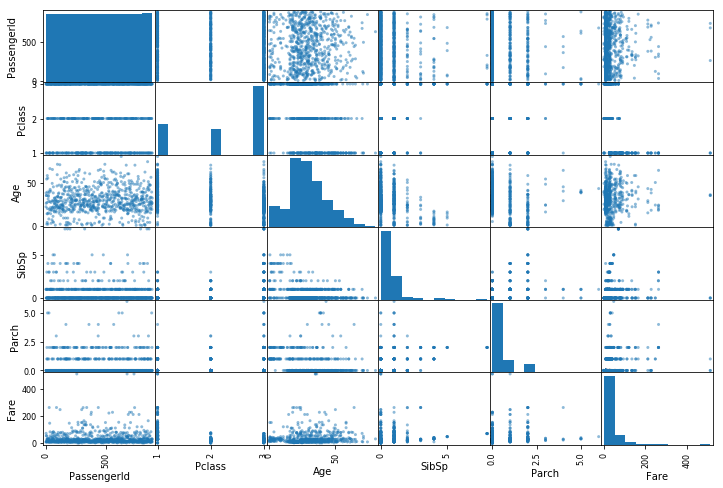

In [35]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_train, figsize=(12,8))
plt.show()

In [106]:
#fooling with adding some feature engineering
raw_data_plus = raw_data.copy()
raw_data_plus['Wealth'] = (1/raw_data_plus['Pclass'])*raw_data_plus['Fare']
raw_data_plus['Status'] = raw_data_plus['Wealth']*raw_data_plus['Age']
raw_data_plus['A_minor'] = (raw_data_plus['Age']<8) & (raw_data_plus['Parch']>0) #accompanied minor


In [107]:
corr_matrix = raw_data_plus.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Wealth         0.267627
Fare           0.257307
Status         0.240353
A_minor        0.143670
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [252]:
#bulding pipeline tools
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

#building custom transformer
Pclass, Fare, Age,Parch = 0,4,1,3
class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    '''
    returns:
    ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Wealth', 'Status', 'A_minor']
    '''
    def __init__(self, drop_uncor=True):
        self.drop_uncor = drop_uncor
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Wealth = (1/X[:,Pclass])*X[:,Fare]                    #an estimation of wealth
        Status = ((1/X[:,Pclass])*X[:,Fare])*X[:,Age]         #wealth times age
        A_minor = (X[:,Age]<8) & (X[:,Parch]>0)               #accompanied minor (y/n)
        return np.c_[X, Wealth, Status, A_minor]              

#building tool to transform between pd and np frames
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, atrib_names):
        self.atrib_names = atrib_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.atrib_names].values
    
class LabelEncoderPipelineFriendly(LabelEncoder):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X[:,1])
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X[:,1])

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X[:,1]).transform(X)

In [253]:
cat_attribs = ['Sex','Embarked', 'Pclass']
num_attribs = X_train.drop(['Sex','Embarked','PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X_train[cat_attribs].dtypes

Sex         object
Embarked    object
Pclass      object
dtype: object

In [274]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Imputer
from sklearn.pipeline import FeatureUnion

cat_attribs = ['Sex','Embarked', 'Pclass']
num_attribs = X_train.drop(['Sex','Embarked','PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1).columns

#building full data pipeline using vatious transformers experimented with above
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributeAdder()),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label-encoder', LabelEncoderPipelineFriendly()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

X_train[cat_attribs] = X_train[cat_attribs].astype(str)
X_train_prepared = num_pipeline.fit_transform(X_train)
X_train_prepared.shape

(891, 8)

In [425]:
#adding onehotencoder manually
X_train_cat = X_train[cat_attribs]
X_train_cat_1hot = pd.get_dummies(X_train_cat).values
print(X_train_cat_1hot.shape)
X_train_final = np.concatenate((X_train_prepared, X_train_cat_1hot), axis=1)
X_train_final.shape

(891, 9)


(891, 17)

In [289]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_final, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [336]:
from sklearn.metrics import confusion_matrix
def get_scores(y_train, y_pred):
    '''
    y train - expected values
    y pred - model given values
    returns recall, precision, fscore
    '''
    confusion = confusion_matrix(y_train, y_pred)
    fp = confusion[0][1] # false_positive
    fn = confusion[1][0] #false_negative
    tp = confusion[1][1] #true_positive
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    fscore = 2 * (precision * recall) / (precision + recall)
    return (precision, recall, fscore)

In [337]:
#measuring accuracy
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(rfc, X_train_final, y_train, cv=5)
np.unique(y_train_pred,return_counts=True)

(array([False,  True]), array([583, 308]))

In [338]:
precision, recall, fscore = get_scores(y_train, y_train_pred)
print("Precision (When claiming someone lives, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of survivors.\nF-score of:",fscore)

Precision (When claiming someone lives, is correct): 78.24675324675324 % of time.
Recall(Model catches): 70.46783625730994 % of survivors.
F-score of: 0.7415384615384616


In [350]:
from sklearn.metrics import roc_auc_score
#perfect classifier area under true_positive_rate v false_positive_rate equals 1
roc_auc_score(y_train, y_train_pred)

0.7913191448566772

In [360]:
from sklearn.model_selection import GridSearchCV as gscv
param_grid = {'n_estimators': range(5,75,5), 'max_features':["auto", 1,5,10,15], 'max_leaf_nodes': [None,2,5,10,20]}
grid_search = gscv(rfc, param_grid, cv=5, scoring = "f1", refit=True)
#fitting the model
grid_search.fit(X_train_final, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(5, 75, 5), 'max_features': ['auto', 1, 5, 10, 15], 'max_leaf_nodes': [None, 2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [361]:
print("Acheaved score of:\t", grid_search.best_score_)
print("With following paramaters:\t", grid_search.best_params_)
print("The model:",grid_search.best_estimator_)

Acheaved score of:	 0.7655240085114028
With following paramaters:	 {'max_features': 15, 'max_leaf_nodes': 20, 'n_estimators': 25}
The model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


In [381]:
final_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
y_pred_final = cross_val_predict(final_model, X_train_final, y_train, cv=10, method = "predict_proba")[:,1] > 0.4
precision, recall, fscore = get_scores(y_train, y_pred_final)
print("Precision (When claiming someone lives, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of survivors.\nF-score of:",fscore)

Precision (When claiming someone lives, is correct): 79.32098765432099 % of time.
Recall(Model catches): 75.14619883040936 % of survivors.
F-score of: 0.7717717717717718


In [441]:
#predictions on test data
test_data = pd.read_csv(local_path+'/test.csv')
test_data[cat_attribs] = test_data[cat_attribs].astype(str)
test_data_prepared = num_pipeline.fit_transform(test_data)
test_data_cat = test_data[cat_attribs]
test_data_cat_1hot = pd.get_dummies(test_data_cat).values
test_data_final = np.concatenate((test_data_prepared, \
                                  test_data_cat_1hot, \
                                  np.zeros((test_data_cat_1hot.shape[0],1), dtype=int))\
                                 , axis=1)

In [442]:
final_model.fit(X_train_final, y_train)
predictions = final_model.predict(test_data_final).astype(int)
test_data['Survived'] = predictions

In [443]:
out = test_data[['PassengerId','Survived']].to_csv(index=False)
f = open("predictions.csv","w+")
f.write(out)
f.close()